# Assignment 02 - CIFAR10 Image Classification

In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645_assignment02_team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team_(team number)_FCN.h5 (fully connected model) and team_(team number)_FCN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.utils import to_categorical # Function to convert labels to one-hot encoding
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Activation,Input 
from tensorflow.keras.optimizers import SGD

## 1. Load your data

In [2]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2. Explore your data 

In [3]:
# Use this space to explore you datasets

print("Development set")
print("Image shape", X_dev.shape)
print("Labels Shape", Y_dev.shape)
print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))

print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)



# Create additional cells as you see fit
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]




Development set
Image shape (50000, 32, 32, 3)
Labels Shape (50000, 1)

Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Test set
Images:  (10000, 32, 32, 3)
Labels shape:  (10000, 1)


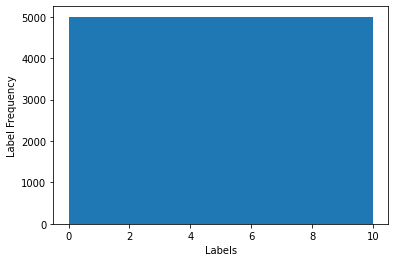

In [4]:
# Class Distribution of Development Set
plt.figure()
plt.hist(Y_dev, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

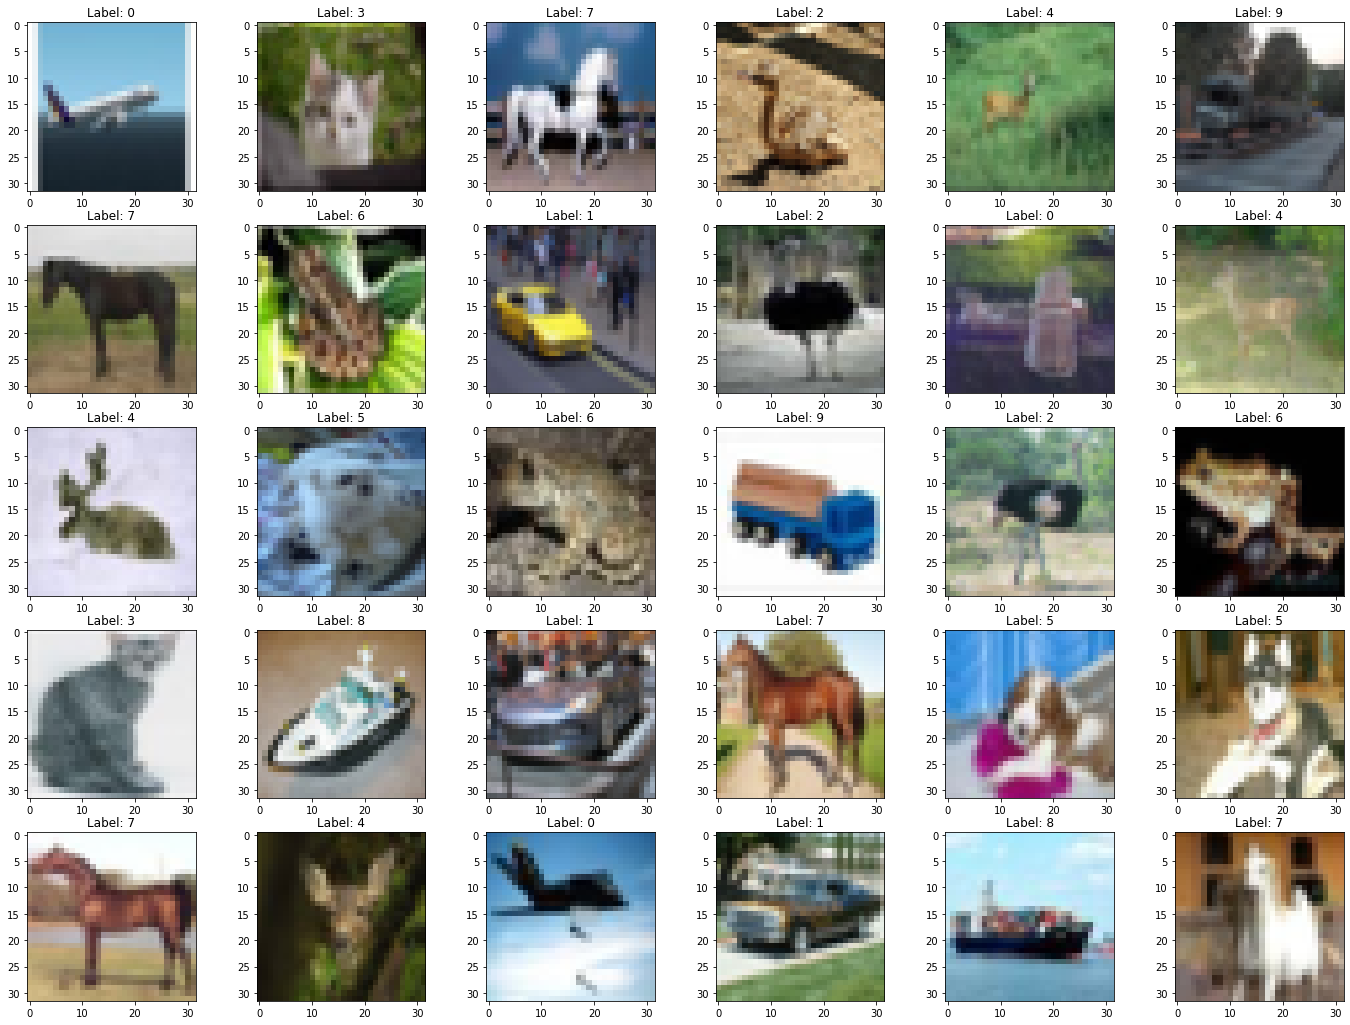

In [5]:
# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()


In [6]:
# Shuffle Data
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (37500, 32, 32, 3)
Labels shape:  (37500, 1)

Validation set
Images:  (12500, 32, 32, 3)
Labels shape:  (12500, 1)


In [7]:
# Training and Validation Set Analysis

print("Train: ",X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print("Test: ",X_val.min(),X_val.max(),X_val.mean(),X_val.std())

Train:  0 255 120.74341871527778 64.17009317395494
Test:  0 255 120.60000434895834 64.08986618587946


## 3. Represent your labels using one hot encoding

In [8]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[[8]
 [2]
 [7]
 [1]
 [0]]

One hot encoded labels:
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 4. Data scaling and Data augmentation

In [9]:
# Experiment with different data scaling methods

norm_type = 1 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
else:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std


In [10]:
# set your batch size
batch_size = 32

gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

#Generation of augmented data:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
datagen.fit(X_train, seed = 1)
augmented = datagen.flow(X_train, Y_train_oh, batch_size=32,shuffle=True)
train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size) 

0.10808829 0.89827174
-1.8779972 2.0921986


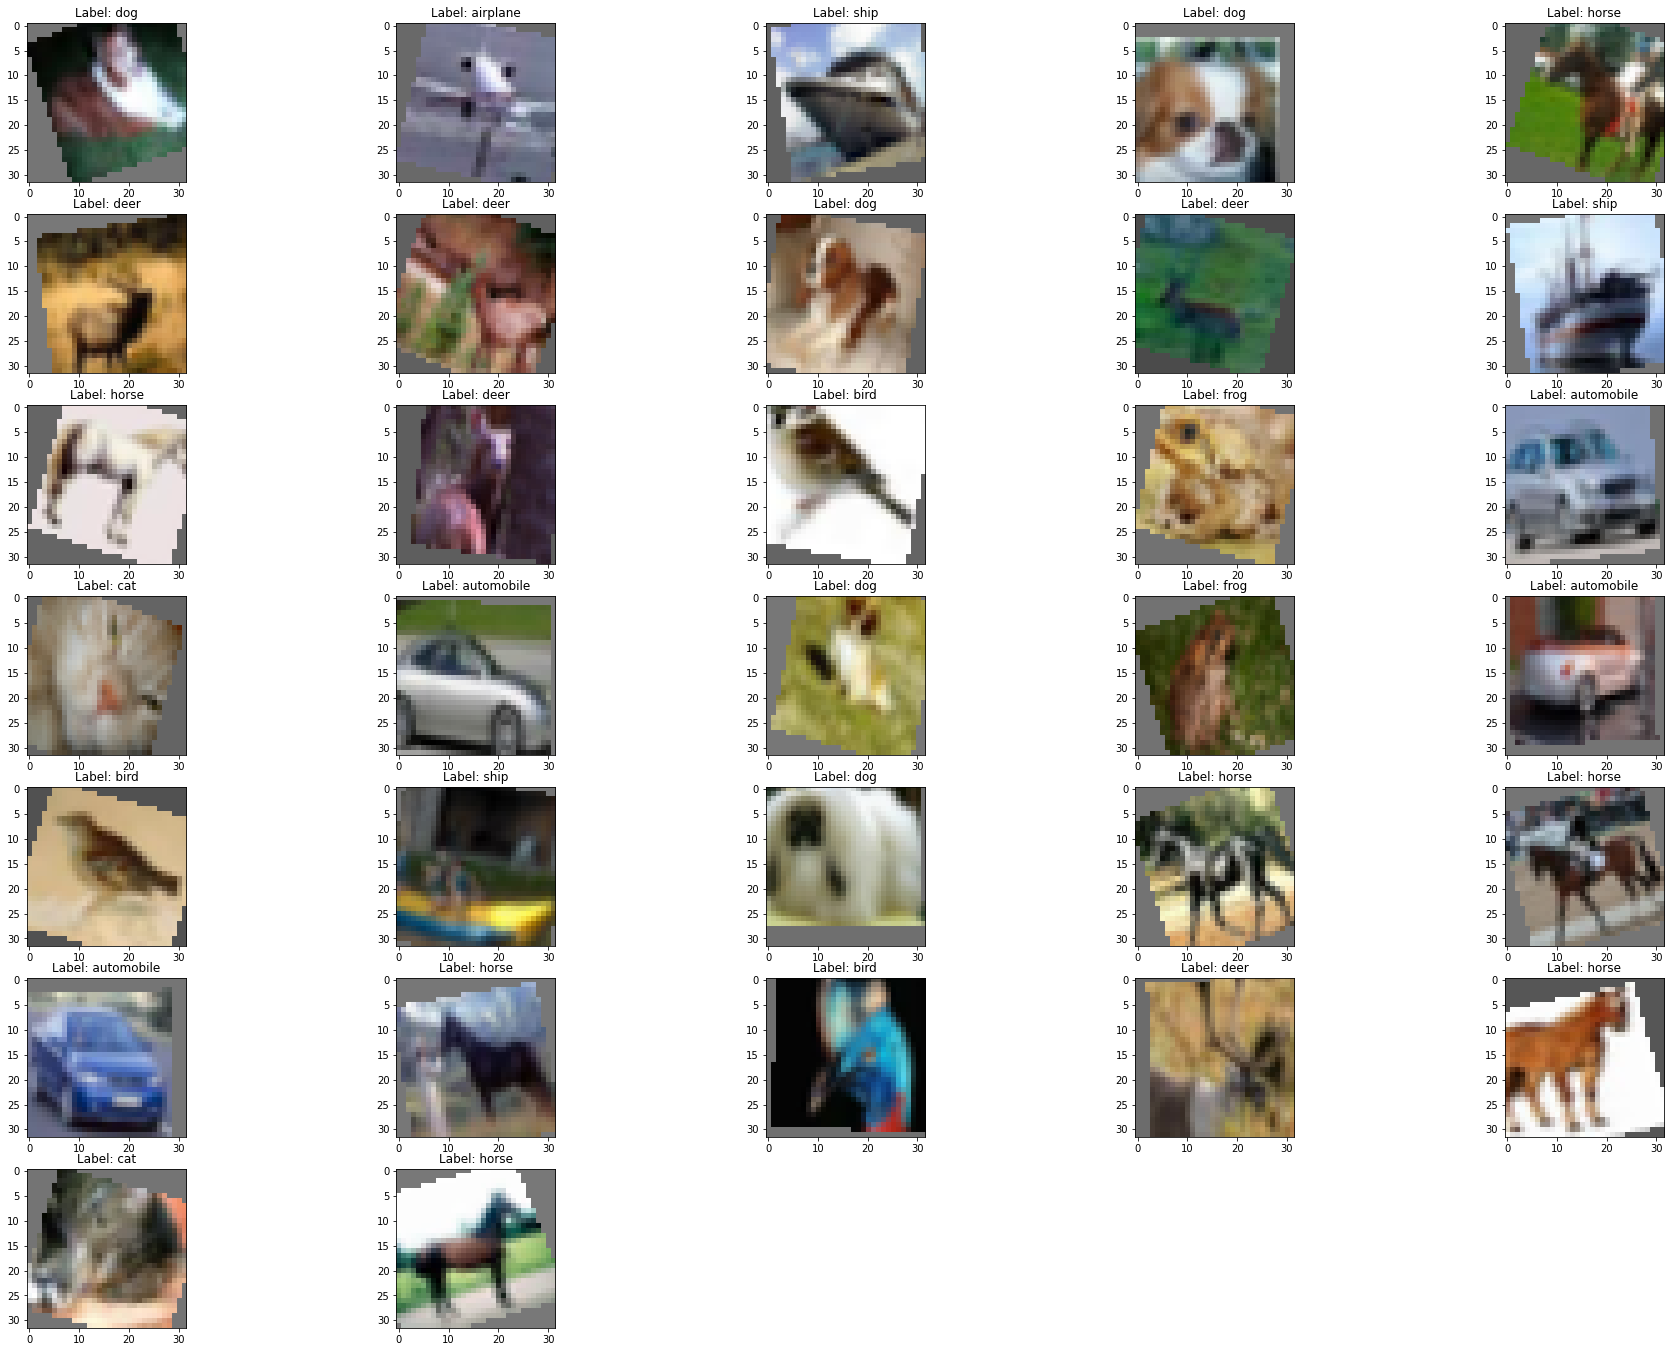

In [11]:
# Disaplying some samples from the development set
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title("Label: %s" %class_names[int(Ybatch[ii].argmax())])
plt.show()

## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
"""
Different model structures were explored. A structure of successive dense layers
was found to give the best results. After one successive dense layers, the test
accuracy went down as the model was found to be overfitting.
A bigger learning rate was found to decrease the training time. But a smaller 
learning rate improved the results
By including dropout, the model performed better but the training time significantly
increased.
"""
def my_model_fully_connected(ishape = (32,32,3),k = 10, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    d1 = tf.keras.layers.Dense(1536,activation = 'relu')(model_input_flatten)
    d1 = tf.keras.layers.Dropout(0.2)(d1)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(d1)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), \
                  loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [ ]:
model = my_model_fully_connected()
print(model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1536)              4720128   
_________________________________________________________________
dropout_26 (Dropout)         (None, 1536)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)                15370     
Total params: 4,735,498
Trainable params: 4,735,498
Non-trainable params: 0
_________________________________________________________________
None


## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_fcn = "team_10_FCN.h5"

# Monitor the validation loss, if there is no improvement in 20 epochs then stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

# Save the model with the best performance on val_loss
monitor = tf.keras.callbacks.ModelCheckpoint(model_name_fcn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')

# Learning rate schedule, every ten epochs lower learning rate by half
def scheduler(epoch, lr):
    if epoch%15 == 0:
        lr = lr/2
    return lr
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [ ]:
# Train model for 1000 epochs or until callbacks kick in
model.fit(X_train,Y_train_oh,batch_size = 32, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/1000
1172/1172 [==============================] - 5s 4ms/step - loss: 1.9957 - accuracy: 0.2817 - val_loss: 1.8185 - val_accuracy: 0.3429
Epoch 2/1000
1172/1172 [==============================] - 4s 4ms/step - loss: 1.7430 - accuracy: 0.3841 - val_loss: 1.6884 - val_accuracy: 0.4094
Epoch 3/1000
1172/1172 [==============================] - 4s 4ms/step - loss: 1.6598 - accuracy: 0.4157 - val_loss: 1.6374 - val_accuracy: 0.4229
Epoch 4/1000
1172/1172 [==============================] - 4s 3ms/step - loss: 1.6062 - accuracy: 0.4323 - val_loss: 1.6079 - val_accuracy: 0.4394
Epoch 5/1000
1172/1172 [==============================] - 4s 3ms/step - loss: 1.5680 - accuracy: 0.4545 - val_loss: 1.5590 - val_accuracy: 0.4514
Epoch 6/1000
1172/1172 [==============================] - 4s 4ms/step - loss: 1.5312 - accuracy: 0.4679 - val_loss: 1.5730 - val_accuracy: 0.4449
Epoch 7/1000
1172/1172 [==============================] - 4s 3ms/step - loss: 1.4869 - accuracy: 0.4853 - val_loss: 1.5590 -

In [ ]:
#Train with augmented data
model.fit(augmented, batch_size = 64, epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

313/313 [==============================] - 1s 2ms/step - loss: 1.2839 - accuracy: 0.5530
Before data augmentation:  4470
313/313 [==============================] - 1s 2ms/step - loss: 1.2839 - accuracy: 0.5530
After data augmentation:  4470


## 8. Test your model

313/313 [==============================] - 1s 2ms/step - loss: 1.3446 - accuracy: 0.5252
4748


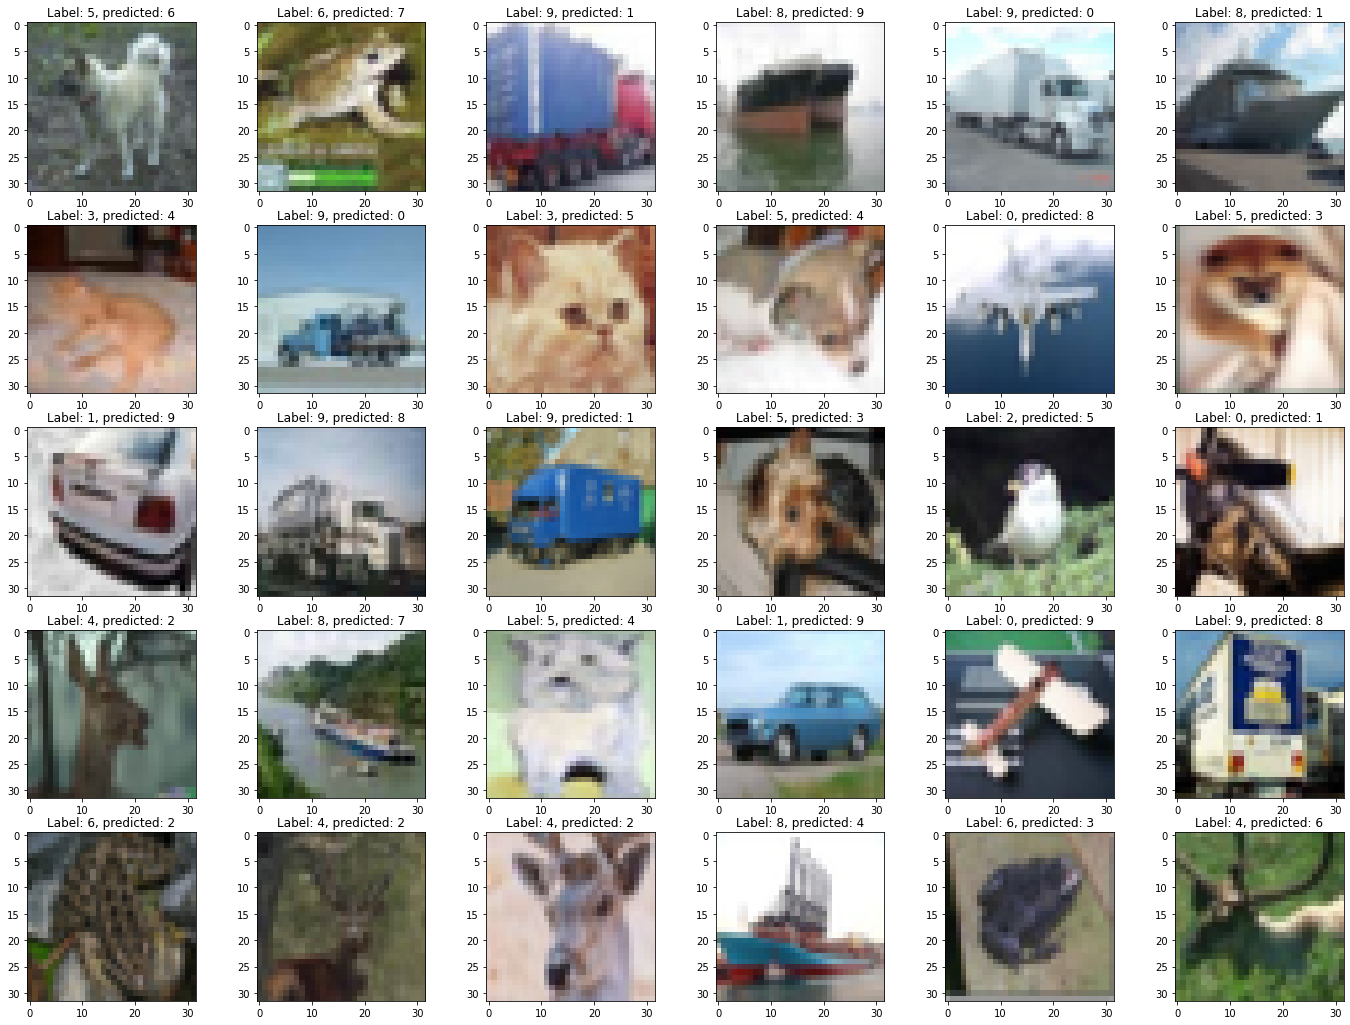

In [ ]:
# Load best model
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

# Predict using test set
Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)


# Disaplying some samples that were predicted incorrectly
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [17]:
"""
This model started out from our class model, using a convolution layer set made up of 32 kernels each with a 3x3 kernel size, connected by a 2x2 MaxPool to another set of convolution layers with 64 kernels and a 3x3 kernel size. This grew to add a 128 kernel, 3x3 kernel size layer set, which improved the accuracy somewhat. Online articles suggested adding an additional fully connected layer, where the dense layer came in with a size of 128, and some improved kernel initialization, batch normalization, and different optimization, all of which improved our preformance somewhat. In addition, changing the scaling parameters brought us close to about 75% accuracy. While this was good, it was suggested to try some different model setups, so further online research gave the idea of inverting the model layers and adding dropouts to reduce overfitting. This worked great, especially with larger layer sizes, and some fine tuning of this brought about the final model, seen below. 
The final model uses a set of 256 kernels, each with a 3x3 kernel size, followed by a 2x2 MaxPool, a 128 kernels with a 3x3 kernel size set of convolution layers, followed by another 2x2 MaxPool, to a final set of 64 kernel, 3x3 kernel size convolution layers. This is connected to a fully connected 128 kernel layer, which finally connects the output layer. Batch normalization and dropouts were used between convolution layers and before the MaxPool 
"""

def my_model_cnn(ishape = (32,32,3),k=10, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)

    l1 = tf.keras.layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(lr), activation='relu')(model_input) 
    l1_batch = tf.keras.layers.BatchNormalization()(l1)

    l2 = tf.keras.layers.Conv2D(256, (3,3), padding='same',kernel_initializer='he_uniform',  kernel_regularizer=tf.keras.regularizers.l2(lr), activation='relu')(l1_batch) 
    l2_batch = tf.keras.layers.BatchNormalization()(l2)
    l2_drop = tf.keras.layers.Dropout(0.2)(l2_batch)

    #MaxPool between convolution layer sets
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)
    l4 = tf.keras.layers.Conv2D(128, (3,3), padding='same',kernel_initializer='he_uniform',  kernel_regularizer=tf.keras.regularizers.l2(lr),activation='relu')(l3) 
    l4_batch = tf.keras.layers.BatchNormalization()(l4)

    l5 = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(lr),activation='relu')(l4) 
    l5_batch = tf.keras.layers.BatchNormalization()(l5)
    l5_drop = tf.keras.layers.Dropout(0.3)(l5_batch)

    #MaxPool between convolution layer sets
    l6 = tf.keras.layers.MaxPool2D((2,2))(l5_drop)
    l7 = tf.keras.layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_uniform',  kernel_regularizer=tf.keras.regularizers.l2(lr),activation='relu')(l6)
    l7_batch = tf.keras.layers.BatchNormalization()(l7)

    l8 = tf.keras.layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(lr), activation='relu')(l7_batch)
    l8_batch = tf.keras.layers.BatchNormalization()(l8)
    l8_drop = tf.keras.layers.Dropout(0.4)(l8_batch)

    #Fully Connected Layers:
    flat = tf.keras.layers.Flatten()(l8_drop)
    prep_out = tf.keras.layers.Dense(128,activation = 'relu', kernel_initializer='he_uniform')(flat)    
    out_drop = tf.keras.layers.Dropout(0.5)(prep_out)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(out_drop)

    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=lr, momentum=0.9), loss='categorical_crossentropy', metrics = ["accuracy"]) #different optimizer that provided better results

    return model


## 6. Define your callbacks (save your model, patience, etc.)

In [18]:
model_name_cnn = "team_10_CNN.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)
# define your callbacks
# remember that you need to save the weights of your best model!
model = my_model_cnn(lr=0.01)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 256)       7168      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0   

## 7. Train your model

In [19]:
# train your model - 200 epochs used
model.fit(X_train,Y_train_oh,batch_size = 32, epochs = 200, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/200
1172/1172 [==============================] - 15s 12ms/step - loss: 13.7946 - accuracy: 0.2981 - val_loss: 4.1268 - val_accuracy: 0.2958
Epoch 2/200
1172/1172 [==============================] - 13s 12ms/step - loss: 2.8249 - accuracy: 0.4719 - val_loss: 1.9512 - val_accuracy: 0.4952
Epoch 3/200
1172/1172 [==============================] - 13s 11ms/step - loss: 1.7308 - accuracy: 0.5445 - val_loss: 1.7317 - val_accuracy: 0.5282
Epoch 4/200
1172/1172 [==============================] - 13s 11ms/step - loss: 1.5250 - accuracy: 0.5979 - val_loss: 1.5050 - val_accuracy: 0.5927
Epoch 5/200
1172/1172 [==============================] - 13s 11ms/step - loss: 1.4573 - accuracy: 0.6246 - val_loss: 1.4028 - val_accuracy: 0.6337
Epoch 6/200
1172/1172 [==============================] - 13s 11ms/step - loss: 1.3870 - accuracy: 0.6487 - val_loss: 1.4406 - val_accuracy: 0.6213
Epoch 7/200
1172/1172 [==============================] - 13s 11ms/step - loss: 1.3589 - accuracy: 0.6613 - val_loss: 

In [21]:
# train your model - using augmented data and previous model, again with a maximum of 200 epochs
model.fit(augmented,batch_size = 32, epochs = 200, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/200
1172/1172 [==============================] - 27s 22ms/step - loss: 0.9469 - accuracy: 0.7783 - val_loss: 0.6766 - val_accuracy: 0.8496
Epoch 2/200
1172/1172 [==============================] - 26s 22ms/step - loss: 0.8157 - accuracy: 0.7955 - val_loss: 0.6482 - val_accuracy: 0.8489
Epoch 3/200
1172/1172 [==============================] - 26s 22ms/step - loss: 0.7613 - accuracy: 0.8087 - val_loss: 0.6297 - val_accuracy: 0.8557
Epoch 4/200
1172/1172 [==============================] - 26s 22ms/step - loss: 0.7455 - accuracy: 0.8113 - val_loss: 0.6106 - val_accuracy: 0.8598
Epoch 5/200
1172/1172 [==============================] - 26s 23ms/step - loss: 0.7317 - accuracy: 0.8190 - val_loss: 0.6111 - val_accuracy: 0.8613
Epoch 6/200
1172/1172 [==============================] - 26s 22ms/step - loss: 0.7199 - accuracy: 0.8209 - val_loss: 0.6064 - val_accuracy: 0.8613
Epoch 7/200
1172/1172 [==============================] - 26s 22ms/step - loss: 0.7106 - accuracy: 0.8263 - val_loss: 0

## 8. Test your model

313/313 [==============================] - 1s 4ms/step - loss: 0.5602 - accuracy: 0.8695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

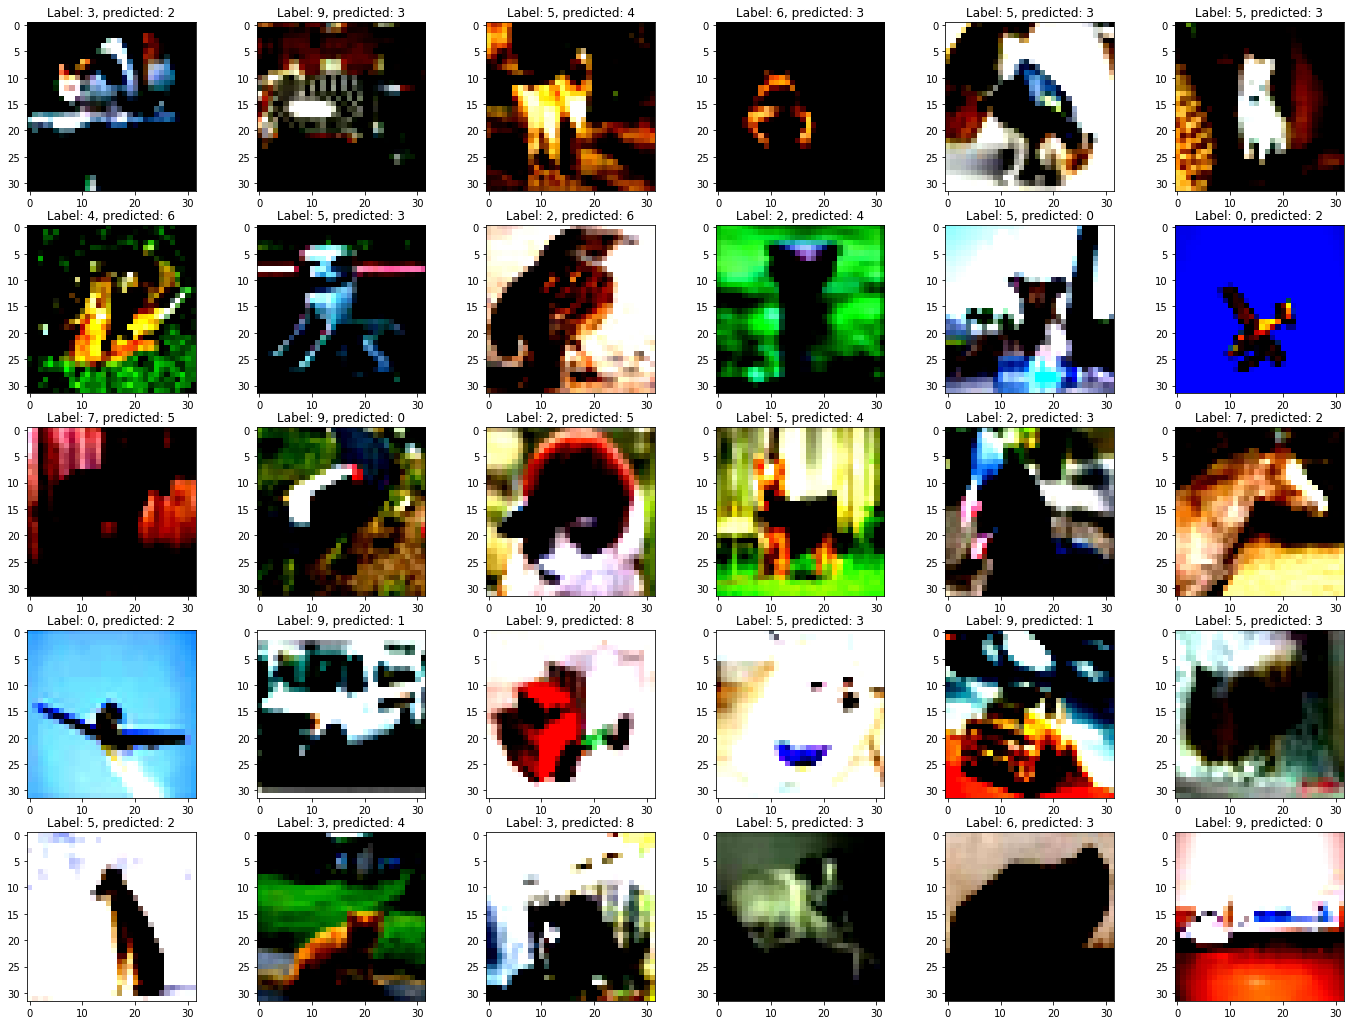

In [22]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Ken Loughery** helped with implementation and design of the CNN model (**score 3**)
- **Nusrat Zenia** helped with implementation and design of the CNN model (**score 3**)
- **Dylan Hofer** helped with implementation and design of the CNN model (**score 3**)
- **Myles Borthwick** helped with implementation and design of FCN model (**score 3**)
- **Gabriel Mathias** helped with implementation and design of FCN model (**score 3**)
- All members contributed to discussions and analysis of both models to ensure that each member has a solid understanding of the alternative functionalities.